# Import libraries

In [3]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.utils import to_categorical
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.callbacks import EarlyStopping

c:\python\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load and preprocess images

In [4]:
direction_classes = ["accelerate", "reverse", "leftTurn", "rightTurn", "leftInPlaceTurn", "rightInPlaceTurn", "stop", "reverseLeft", "reverseRight"]

directory_path = r"C:\Users\tomca\PycharmProjects\rc car\rc_controller\captured_images"

image_paths = []
directions = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".jpg"):
         # The last part "zzz" of the filename xxx_yyy_zzz is the direction control
        direction = filename.split('_')[-1][:-4]
        
        # Construct the full path to the image
        image_path = os.path.join(directory_path, filename)
        
        # Append the data to the lists
        image_paths.append(image_path)
        directions.append(direction)

# Image Augmentation
For artificially increasing the amount of data for training and testing. This can prevent overfitting.\
Geometric transformation – flipping, zooming, cropping, panning...\
Color space transformatinos  –change RGB channelge

In [5]:
from scipy import ndimage

def zoom(image):
    # Specify the zoom factor
    zoom_factor = 1.5
    
    # Resize the image and return
    return ndimage.zoom(image, zoom_factor)

def adjust_brightness(image, max_delta=30):
    # Randomly adjust the brightness of the image
    delta = np.random.uniform(-max_delta, max_delta)
    image = cv2.add(image, np.array([delta]))
    return image

def translate_shift(image, max_translation=20):
    # Randomly translate (shift) the image horizontally and/or vertically
    rows, cols, _ = image.shape
    dx = np.random.uniform(-max_translation, max_translation)
    dy = np.random.uniform(-max_translation, max_translation)
    translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    image = cv2.warpAffine(image, translation_matrix, (cols, rows))
    return image

def perform_random_augmentation(image, direction):
    # Randomly pick and apply augmentation to the image
    augmentations = [
        adjust_brightness, translate_shift
    ]

    selected_augmentations = np.random.choice(augmentations, np.random.randint(1, len(augmentations)), replace=False)

    for augmentation in selected_augmentations:
        image = augmentation(image)

    return image, direction

# Preprocess images

In [6]:
def preprocess_images(image_paths, directions, target_size=(224, 224)):
    target_size = (224, 224)
    images = []
    augmented_directions = []
    for path, direction in zip(image_paths, directions):
        # Load image using cv2
        image = cv2.imread(path)
        
        # Check if image is loaded successfully
        if image is None:
            print(f"Failed to load image: {path}")
            continue
        
        # Resize the image to the target size
        image = cv2.resize(image, target_size)
        
        # Perform random augmentation
        augmented_image, augmented_direction = perform_random_augmentation(image, direction)

        # Normalize image
        image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        augmented_image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # Append the processed image and augmented classifier to the list
        images.append(image)
        images.append(augmented_image)
        augmented_directions.append(direction)
        augmented_directions.append(augmented_direction)
    
    return np.array(images), np.array(augmented_directions)

In [7]:
# Apply preprocessing
images, directions_processed = preprocess_images(image_paths, directions)

# Label encoding

In [8]:
label_encoder = LabelEncoder()

# Convert categorical values into integers
encoded_directions = label_encoder.fit_transform(directions_processed)

# For neural networks, it is also recommended to apply one hot encoding
onehot_encoded_directions = to_categorical(encoded_directions)

# Train/Test split
80/20 split is generally a good starting point.

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split( images, onehot_encoded_directions, test_size=0.2)
print(f"Training data: {len(X_train)}\nValidation data: {len(X_valid)}")

Training data: 953
Validation data: 239


# Model
## Creating the model

In [10]:
# num_classes = len(directions)

model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    # Fully connected layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),  # Adding dropout layer to further prevent overfitting
    layers.Dense(4, activation='softmax')
])

## Compile model

In [11]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/100


30/30 [==============================] - 9s 242ms/step - loss: 1.6383 - accuracy: 0.3861 - val_loss: 1.3417 - val_accuracy: 0.3096
Epoch 2/100
30/30 [==============================] - 7s 234ms/step - loss: 1.2403 - accuracy: 0.4271 - val_loss: 1.2832 - val_accuracy: 0.4979
Epoch 3/100
30/30 [==============================] - 7s 233ms/step - loss: 1.1995 - accuracy: 0.4617 - val_loss: 1.2627 - val_accuracy: 0.4937
Epoch 4/100
30/30 [==============================] - 7s 243ms/step - loss: 1.1316 - accuracy: 0.4932 - val_loss: 1.2146 - val_accuracy: 0.5607
Epoch 5/100
30/30 [==============================] - 7s 244ms/step - loss: 1.0303 - accuracy: 0.5603 - val_loss: 1.0134 - val_accuracy: 0.6151
Epoch 6/100
30/30 [==============================] - 7s 235ms/step - loss: 0.8964 - accuracy: 0.6191 - val_loss: 0.9111 - val_accuracy: 0.6569
Epoch 7/100
30/30 [==============================] - 7s 235ms/step - loss: 0.7842 - accuracy: 0.6821 - val_loss: 0.7887 - val_accuracy: 0.69

## Model summary

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 32)        0

# Plot accuracy over epochs

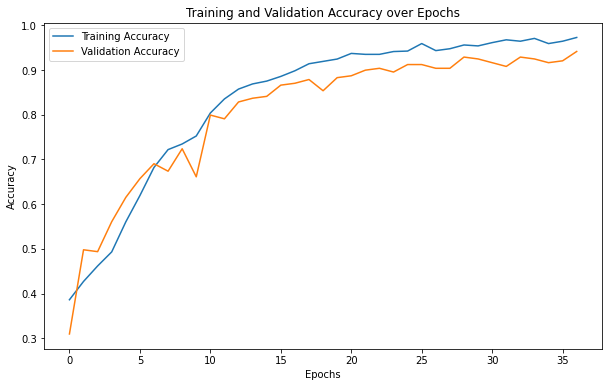

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss over epochs

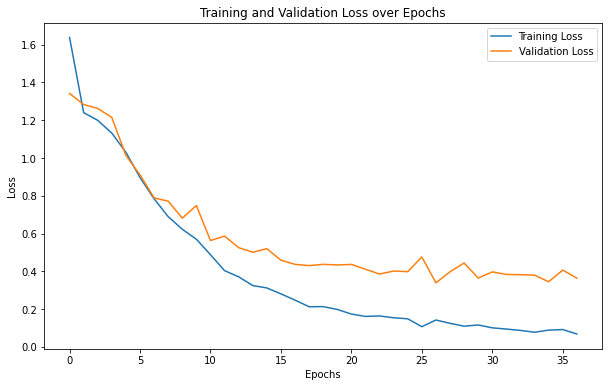

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Classification metrics

In [16]:
# Convert multilabel-indicator to multiclass format
y_valid_multiclass = np.argmax(y_valid, axis=1)

# Evaluate the model on the validation set
y_pred_valid = model.predict(X_valid)
y_pred_valid_classes = np.argmax(y_pred_valid, axis=1)

# Calculate and print classification metrics
accuracy_valid = accuracy_score(y_valid_multiclass, y_pred_valid_classes)
precision_valid = precision_score(y_valid_multiclass, y_pred_valid_classes, average='weighted')
recall_valid = recall_score(y_valid_multiclass, y_pred_valid_classes, average='weighted')
f1_valid = f1_score(y_valid_multiclass, y_pred_valid_classes, average='weighted')

print(f"Validation Accuracy: {accuracy_valid}")
print(f"Validation Precision: {precision_valid}")
print(f"Validation Recall: {recall_valid}")
print(f"Validation F1 Score: {f1_valid}")

8/8 [==============================] - 0s 43ms/step
Validation Accuracy: 0.9414225941422594
Validation Precision: 0.9421920339075149
Validation Recall: 0.9414225941422594
Validation F1 Score: 0.9410306179192494


# Save model

In [17]:
import os

# Create directory if it doesn't exist
save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'model_v1.keras'))